In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [13]:
def data_preprocessing(data):
    #Prepare the dataset
    # Convert Open Time to datetime and extract useful features
    data = data.drop(columns=["Open Time", "Coin"]) 
    # Define features and target
    X = data.drop(columns=["Close"])
    y = data["Close"]
    
    return X, y

In [14]:
def scaling_train_test_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test

In [15]:
def train_model(X_train_scaled, y_train):
    ## Train XGBoost model
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1, random_state=42)
    xgb_model.fit(X_train_scaled, y_train)
    return xgb_model

In [16]:
def evaluate_model(X_train_scaled, X_test_scaled, y_train, y_test, xgb_model, currency):
    y_pred = xgb_model.predict(X_test_scaled)
    # Evaluate model
    train_score = xgb_model.score(X_train_scaled, y_train)
    test_score = xgb_model.score(X_test_scaled, y_test)
    print(f"Train score for {currency}:" + str(train_score))
    print(f"Test score for {currency}:" + str(test_score))
    return y_pred
    

In [17]:
def plot_comparison(y_test, y_pred, currency):
    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.values[:100], label="Actual", linestyle="-", marker="o", alpha=0.7)  # First 100 points
    plt.plot(y_pred[:100], label="Predicted", linestyle="-", marker="x", alpha=0.7)

    plt.xlabel("Time (minutes)")
    plt.ylabel("Closing Price (USD)")
    plt.title(f"Actual vs. Predicted Closing Prices (First 100 Minutes of Training Dataset) - {currency}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [18]:
def next_minute_price(X, model):
    # Predict the next minute's closing price
    next_minute_price = model.predict(X.iloc[-1].values.reshape(1, -1))[0]
    if next_minute_price > X['Close'].iloc[-1]:
        print(f"The price will increase from ${X['Close'].iloc[-1]} to ${next_minute_price}")
    elif next_minute_price < X['Close'].iloc[-1]:
        print(f"The price will decrease from ${X['Close'].iloc[-1]} to ${next_minute_price}")

##### 1. Training with Indicators (MACD & RSI)

In [19]:
# Load your dataset
file_path = "processed_data/BTC_1m_data_indicators.csv"  # Update if needed
df = pd.read_csv(file_path)

In [20]:
# Load the datasets
btc_indicators = pd.read_csv("processed_data/BTC_1m_data_indicators.csv")
eth_indicators = pd.read_csv("processed_data/ETH_1m_data_indicators.csv")
xrp_indicators = pd.read_csv("processed_data/XRP_1m_data_indicators.csv")
solana_indicators = pd.read_csv("processed_data/SOL_1m_data_indicators.csv")


In [21]:
X_btc, y_btc = data_preprocessing(btc_indicators)
X_eth, y_eth = data_preprocessing(eth_indicators)
X_xrp, y_xrp = data_preprocessing(xrp_indicators)
X_sol, y_sol = data_preprocessing(solana_indicators)

In [22]:
# X_train and X_test are scaled 
X_train_btc, X_test_btc, y_train_btc, y_test_btc = scaling_train_test_split(X_btc, y_btc)
X_train_eth, X_test_eth, y_train_eth, y_test_eth = scaling_train_test_split(X_eth, y_eth)
X_train_xrp, X_test_xrp, y_train_xrp, y_test_xrp = scaling_train_test_split(X_xrp, y_xrp)
X_train_sol, X_test_sol, y_train_sol, y_test_sol = scaling_train_test_split(X_sol, y_sol)

In [23]:
btc_model= train_model(X_train_btc, y_train_btc)
eth_model = train_model(X_train_eth, y_train_eth)
xrp_model = train_model(X_train_xrp, y_train_xrp)
solana_model = train_model(X_train_sol, y_train_sol)

In [26]:
y_pred_btc = evaluate_model(X_train_btc, X_test_btc, y_train_btc, y_test_btc, btc_model,'BTC')
y_pred_eth = evaluate_model(X_train_eth, X_test_eth, y_train_eth, y_test_eth, eth_model, 'ETH')
y_pred_xrp = evaluate_model(X_train_xrp, X_test_xrp, y_train_xrp, y_test_xrp, xrp_model, 'XRP')
y_pred_sol = evaluate_model(X_train_sol, X_test_sol, y_train_sol, y_test_sol, solana_model, 'SOL')

Train score for BTC:0.9999038273936711
Test score for BTC:0.9386306479748676
Train score for ETH:0.9999432087964238
Test score for ETH:0.9533356046347241
Train score for XRP:0.9999508429209685
Test score for XRP:0.9989286196989684
Train score for SOL:0.9999168199745362
Test score for SOL:0.4139705959700549


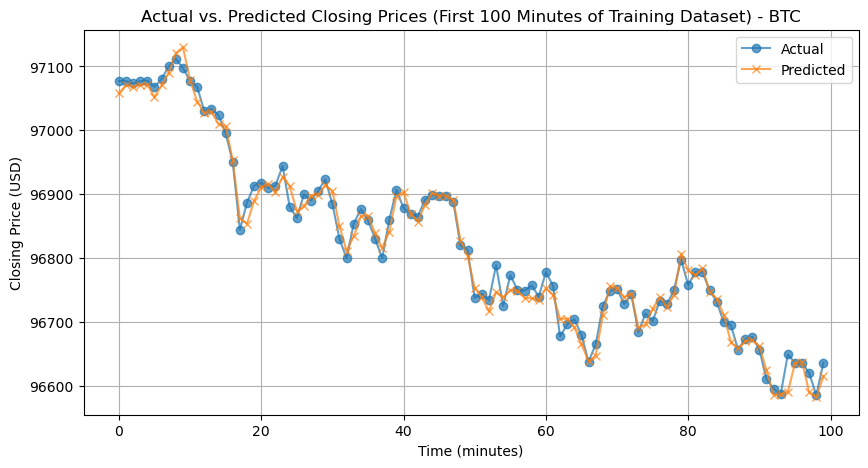

In [27]:
plot_comparison(y_test_btc, y_pred_btc, 'BTC')

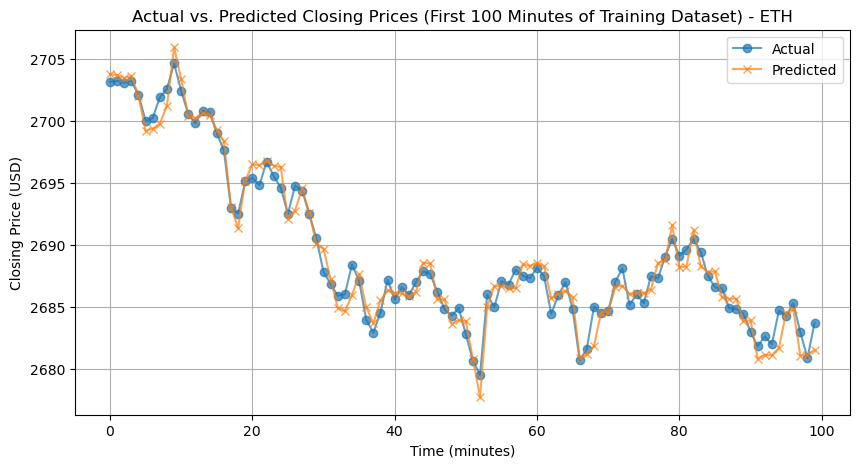

In [28]:
plot_comparison(y_test_eth, y_pred_eth, 'ETH')

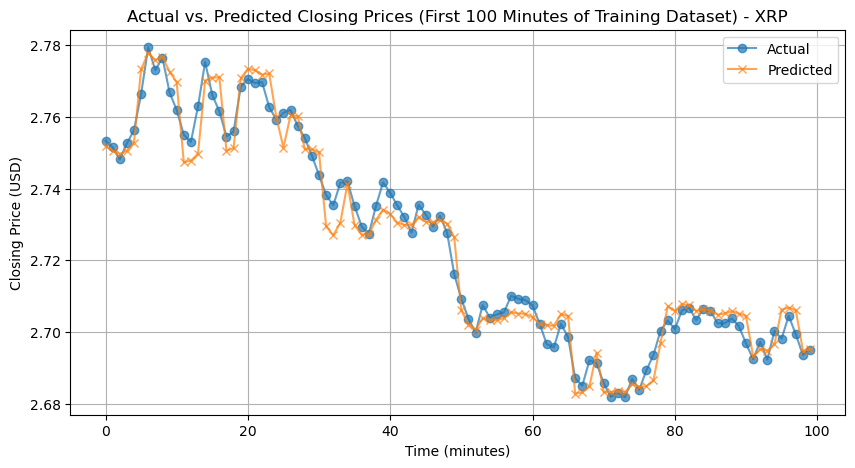

In [29]:
plot_comparison(y_test_xrp, y_pred_xrp, 'XRP')

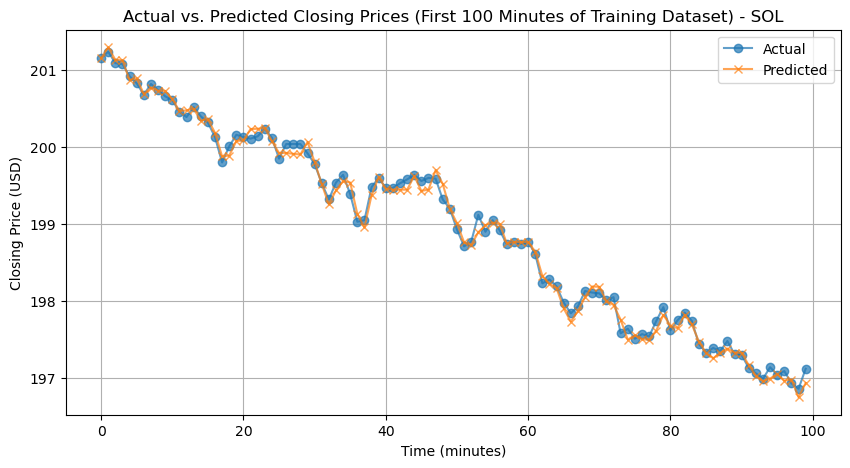

In [30]:
plot_comparison(y_test_sol, y_pred_sol, 'SOL')